# &#x1F4D1; &nbsp;  Image Generator of Digits
## Libraries

In [1]:
%%html
<style>        
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>

In [2]:
import numpy as np 
import pandas as pd
import math
from scipy import misc
from collections import namedtuple

import cv2
from PIL import ImageFile, Image
from tqdm import tqdm
from glob import glob

from keras.preprocessing import image as keras_image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tflearn

from keras.layers import Input, Dense, Reshape
from keras.layers import Activation, LeakyReLU, BatchNormalization, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
from keras import backend

from tflearn.data_utils import build_hdf5_image_dataset

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Datasets

In [3]:
df_train = pd.read_csv("kaggle_digits_train.csv")
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
digit_images = np.array(df_train[images])
digit_images = digit_images.astype('float32').reshape(-1, 784)
digit_images.shape

(42000, 784)

In [4]:
df_test = pd.read_csv("kaggle_digits_test.csv")
test_images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
test_digit_images = np.array(df_test[images])
test_digit_images = test_digit_images.astype('float32').reshape(-1, 784)
test_digit_images.shape

(28000, 784)

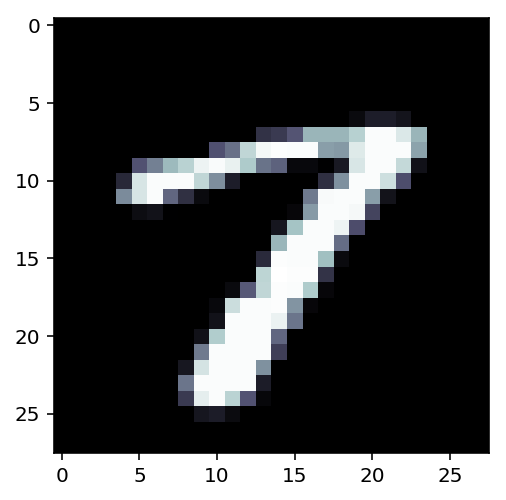

In [5]:
plt.imshow(np.squeeze(digit_images[3000].reshape(28, 28)), cmap=cm.bone);

In [6]:
def latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))
latent_sample_784 = latent_samples(1, 784)
latent_sample_128 = latent_samples(1, 128)

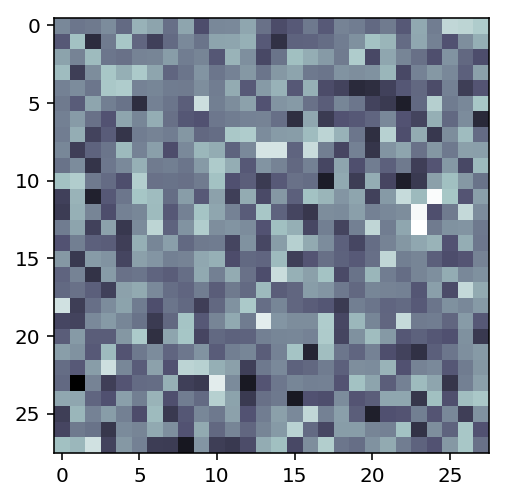

In [7]:
plt.imshow(np.squeeze(latent_sample_784).reshape(28, 28), cmap=cm.bone);

## Keras GAN
[`"Using GAN for Generating Hand-written Digit Images" by Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb) 

In [8]:
discriminator = Sequential([Dense(128, input_shape=(784,)),
                            LeakyReLU(alpha=0.01),
                            Dense(1),
                            Activation('sigmoid')], 
                           name='discriminator')

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


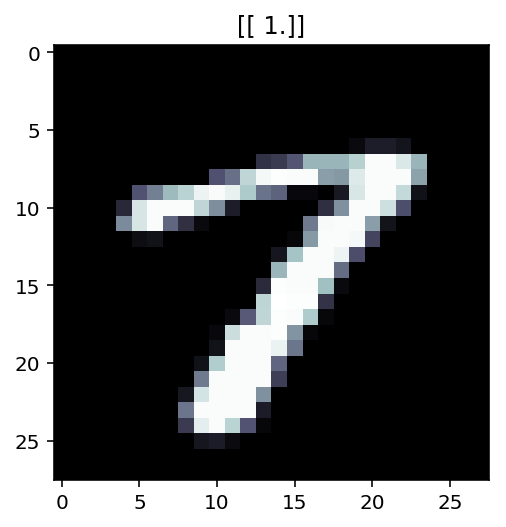

In [9]:
plt.title(discriminator.predict(digit_images[3000].reshape(1,784)))
plt.imshow(np.squeeze(digit_images[3000].reshape(28, 28)), cmap=cm.bone);

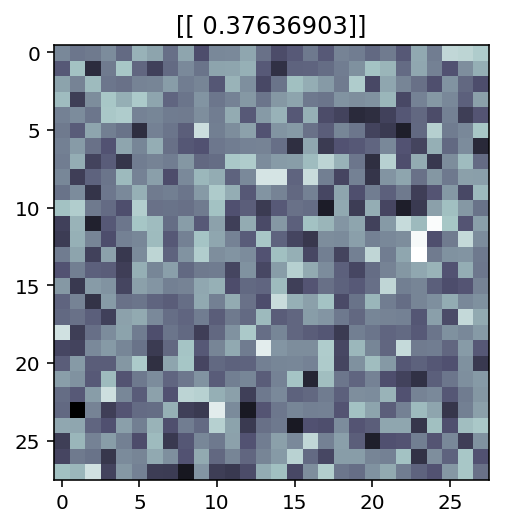

In [10]:
plt.title(discriminator.predict(latent_sample_784))
plt.imshow(np.squeeze(latent_sample_784).reshape(28, 28), cmap=cm.bone);

In [11]:
generator = Sequential([Dense(512, input_shape=(128,)),
                        LeakyReLU(alpha=0.01),
                        Dense(784),
                        Activation('tanh')], 
                       name='generator')

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
_________________________________________________________________
activation_2 (Activation)    (None, 784)               0         
Total params: 468,240
Trainable params: 468,240
Non-trainable params: 0
_________________________________________________________________


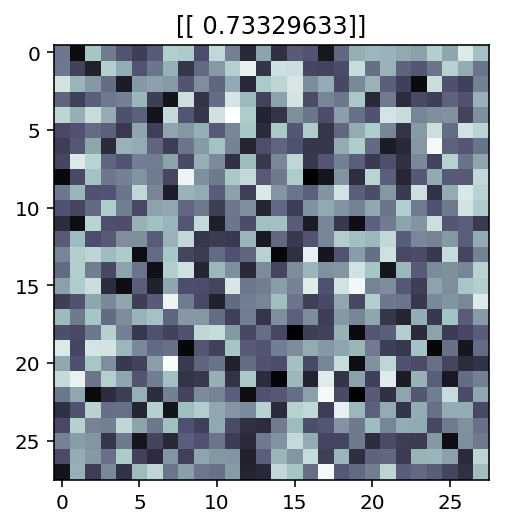

In [12]:
generated_latent_sample = generator.predict(latent_sample_128)
plt.title(discriminator.predict(generated_latent_sample))
plt.imshow(generated_latent_sample.reshape(28, 28), cmap=cm.bone);

In [13]:
gan = Sequential([generator,discriminator])

gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 784)               468240    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 100609    
Total params: 568,849
Trainable params: 568,849
Non-trainable params: 0
_________________________________________________________________


In [14]:
def trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [15]:
def simple_GAN(sample_size, 
               g_hidden_size, 
               d_hidden_size, 
               leaky_alpha, 
               g_learning_rate,
               d_learning_rate):
    
    backend.clear_session()
    
    generator = Sequential([Dense(g_hidden_size, input_shape=(sample_size,)),
                            LeakyReLU(alpha=leaky_alpha),
                            Dense(784), Activation('tanh')], 
                           name='generator')    

    discriminator = Sequential([Dense(d_hidden_size, input_shape=(784,)),
                                LeakyReLU(alpha=leaky_alpha),
                                Dense(1),
                                Activation('sigmoid')], 
                               name='discriminator')    
    
    gan = Sequential([generator, discriminator])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [16]:
np.argmax(digit_images)/255

0.52156862745098043

In [17]:
def preprocess(x):    
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [18]:
X_train_real = preprocess(digit_images)
X_test_real  = preprocess(test_digit_images)

In [56]:
def display_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cm.bone)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show();

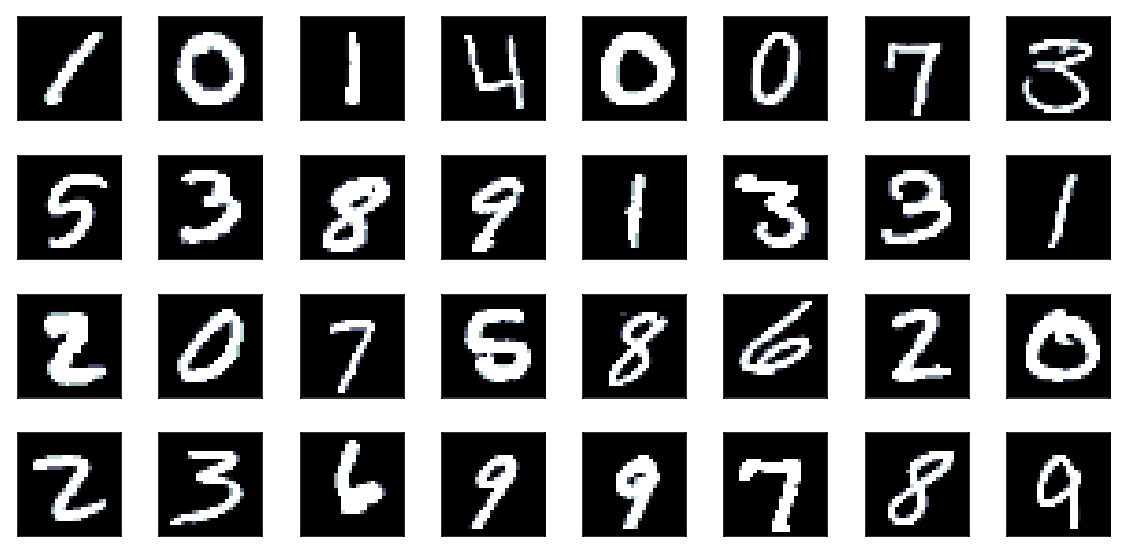

In [59]:
display_images(X_train_real[:32])

In [21]:
def real_fake_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [22]:
y_real5, y_fake5 = real_fake_labels(5)
print('Real\n', y_real5)
print('Fake\n', y_fake5)

Real
 [[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
Fake
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [25]:
sample_size     = 128     
g_hidden_size   = 512     # generator
d_hidden_size   = 128     # discriminator
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # generator
d_learning_rate = 0.001   # discriminator
epochs          = 250
batch_size      = 64      
valid_size      = 16     
smooth          = 0.1

In [26]:
y_train_real, y_train_fake = real_fake_labels(batch_size)
y_valid_real,  y_valid_fake  = real_fake_labels(valid_size)

gan, generator, discriminator = simple_GAN(sample_size, 
                                           g_hidden_size, 
                                           d_hidden_size, 
                                           leaky_alpha, 
                                           g_learning_rate,
                                           d_learning_rate)

In [27]:
losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        batch_latent_samples = latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(batch_latent_samples)
        
        # train the discriminator to detect real and fake images
        trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        trainable(discriminator, False)
        gan.train_on_batch(batch_latent_samples, y_train_real)
    
    # evaluate
    X_valid_real = X_test_real[np.random.choice(len(X_test_real), valid_size, replace=False)]
    
    valid_latent_samples = latent_samples(valid_size, sample_size)
    X_valid_fake = generator.predict_on_batch(valid_latent_samples)

    d_loss  = discriminator.test_on_batch(X_valid_real, y_valid_real)
    d_loss += discriminator.test_on_batch(X_valid_fake, y_valid_fake)
    g_loss  = gan.test_on_batch(valid_latent_samples, y_valid_real) 
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}"\
          .format(e+1, epochs, d_loss, g_loss))
    
generator.save('gan_generator.h5')

Epoch:   1/250 Discriminator Loss: 0.2388 Generator Loss: 3.7963
Epoch:   2/250 Discriminator Loss: 0.2108 Generator Loss: 2.6852
Epoch:   3/250 Discriminator Loss: 0.3336 Generator Loss: 3.3601
Epoch:   4/250 Discriminator Loss: 0.3331 Generator Loss: 1.8057
Epoch:   5/250 Discriminator Loss: 0.5616 Generator Loss: 2.1570
Epoch:   6/250 Discriminator Loss: 0.7934 Generator Loss: 4.0193
Epoch:   7/250 Discriminator Loss: 0.3439 Generator Loss: 2.0533
Epoch:   8/250 Discriminator Loss: 0.4279 Generator Loss: 2.9703
Epoch:   9/250 Discriminator Loss: 0.3606 Generator Loss: 2.1758
Epoch:  10/250 Discriminator Loss: 0.1519 Generator Loss: 3.1448
Epoch:  11/250 Discriminator Loss: 0.6454 Generator Loss: 5.5778
Epoch:  12/250 Discriminator Loss: 0.2473 Generator Loss: 2.2799
Epoch:  13/250 Discriminator Loss: 0.2173 Generator Loss: 3.6808
Epoch:  14/250 Discriminator Loss: 0.2770 Generator Loss: 2.9385
Epoch:  15/250 Discriminator Loss: 0.3337 Generator Loss: 3.5542
Epoch:  16/250 Discrimina

Epoch: 128/250 Discriminator Loss: 1.3228 Generator Loss: 1.2164
Epoch: 129/250 Discriminator Loss: 0.8140 Generator Loss: 1.3830
Epoch: 130/250 Discriminator Loss: 0.9801 Generator Loss: 1.4278
Epoch: 131/250 Discriminator Loss: 0.6482 Generator Loss: 1.9068
Epoch: 132/250 Discriminator Loss: 0.9791 Generator Loss: 1.6735
Epoch: 133/250 Discriminator Loss: 0.7893 Generator Loss: 1.6719
Epoch: 134/250 Discriminator Loss: 1.2915 Generator Loss: 1.1975
Epoch: 135/250 Discriminator Loss: 1.0720 Generator Loss: 1.5284
Epoch: 136/250 Discriminator Loss: 0.8258 Generator Loss: 1.4163
Epoch: 137/250 Discriminator Loss: 0.9550 Generator Loss: 1.5253
Epoch: 138/250 Discriminator Loss: 0.7360 Generator Loss: 1.6653
Epoch: 139/250 Discriminator Loss: 1.1751 Generator Loss: 1.3418
Epoch: 140/250 Discriminator Loss: 1.2987 Generator Loss: 1.1992
Epoch: 141/250 Discriminator Loss: 0.9527 Generator Loss: 1.4736
Epoch: 142/250 Discriminator Loss: 1.6950 Generator Loss: 1.5881
Epoch: 143/250 Discrimina

In [55]:
def display_loss(losses):
    losses = np.array(losses)    
    
    plt.figure(figsize=(18, 6))
    plt.plot(losses.T[0], '-o', c='#37c9e1', lw=1, label='Discriminator')
    plt.plot(losses.T[1], '-o', c='#39d4be', lw=1, label='Generator')
    plt.title("Training Loss Functions")
    plt.legend();

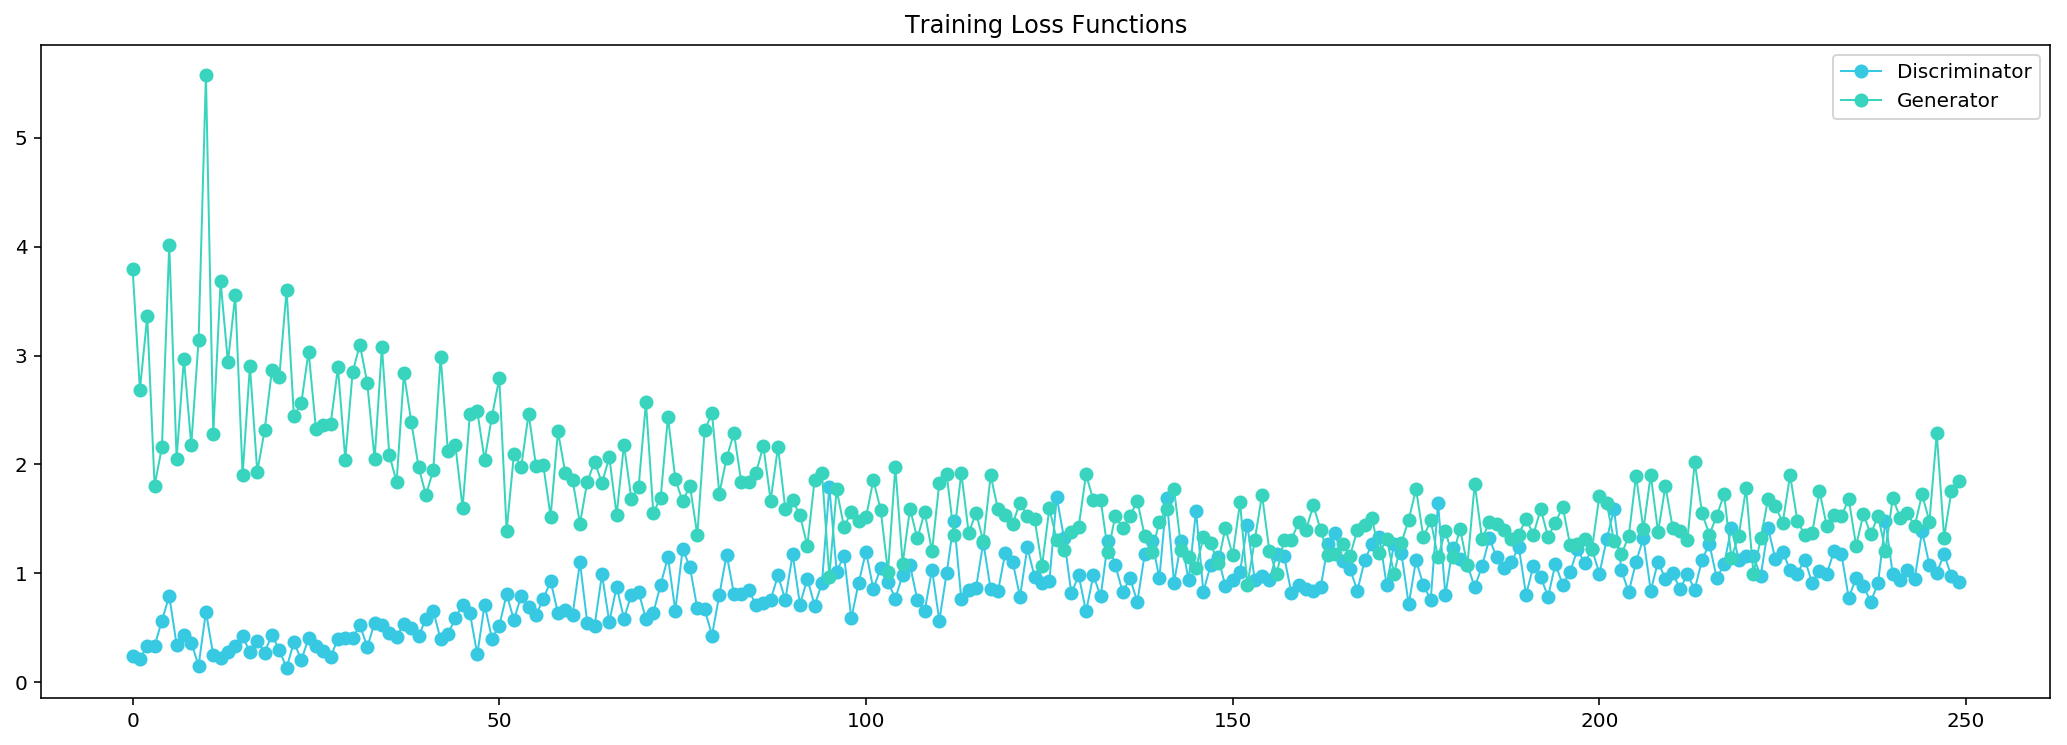

In [60]:
display_loss(losses)

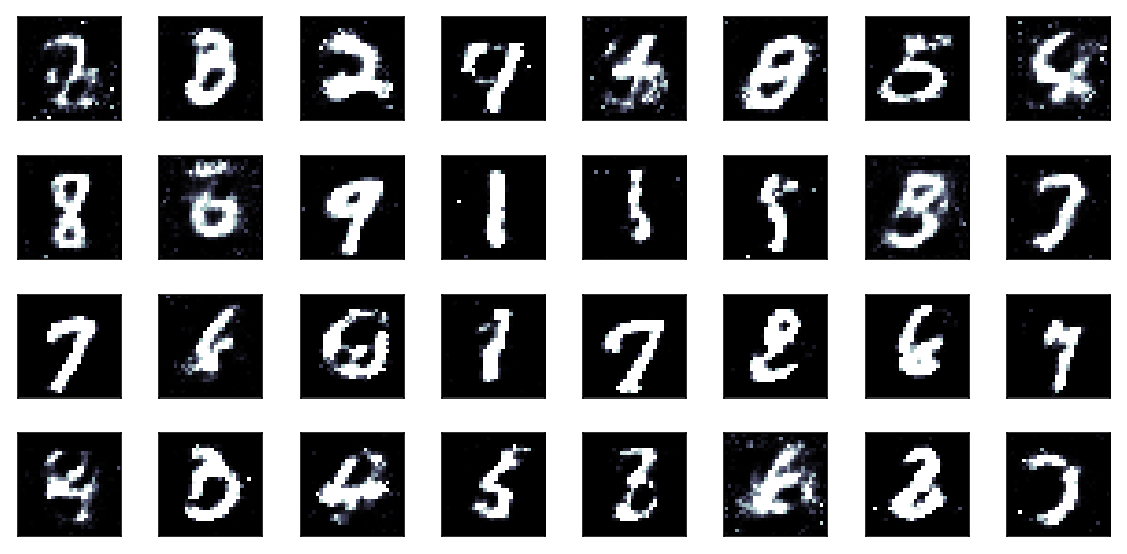

In [29]:
latent_examples = latent_samples(32, sample_size)
generated_digits = generator.predict(latent_examples)

plt.figure(figsize=(8, 4))
for i in range(32):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 8, i+1)
    plt.imshow(img, cmap=cm.bone)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

## Keras DCGAN
[`"Deep Convolutional GAN (DCGAN) with MNIST" by Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/dcgan_mnist.ipynb) 

In [49]:
X_train_real = X_train_real.reshape(-1, 28, 28, 1)
X_test_real = X_test_real.reshape(-1, 28, 28, 1)

In [50]:
def dcgan_generator(input_size, leaky_alpha):
    # Input: 28,28,1
    return Sequential([
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        # Output: 7,7,16
        
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        # Output: 14,14,32

        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
        # Output: 28,28,1
    ])

In [51]:
dcgan_generator_example = dcgan_generator(784, 0.01)
dcgan_generator_example.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 784)               615440    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 32)        0         
__________

In [52]:
def dcgan_discriminator(leaky_alpha):
    # Input: 28,28,1
    return Sequential([        
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        # Output: 14,14,32

        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        # Output: 7,7,16
        
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        # Output: 784
        
        Dense(1),
        Activation('sigmoid')
        # Output: 1
    ])

In [53]:
dcgan_discriminator_example = dcgan_discriminator(0.01)
dcgan_discriminator_example.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)          12816     
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               615440    
__________

In [54]:
def dcgan(sample_size, 
          g_learning_rate, g_beta_1,
          d_learning_rate, d_beta_1,
          leaky_alpha):
    # clear first
    backend.clear_session()
    
    # generator
    generator = dcgan_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = dcgan_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [57]:
def dcgan_train(g_learning_rate, g_beta_1,
                d_learning_rate, d_beta_1,
                leaky_alpha, 
                smooth=0.1,
                sample_size=128,
                epochs=100,
                batch_size=128,
                valid_size=32,
                show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = real_fake_labels(batch_size)
    y_valid_real,  y_valid_fake  = real_fake_labels(valid_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = dcgan(sample_size, 
                                          g_learning_rate, g_beta_1,
                                          d_learning_rate, d_beta_1,
                                          leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            batch_latent_samples = latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(batch_latent_samples)

            # train the discriminator to detect real and fake images
            trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            trainable(discriminator, False)
            gan.train_on_batch(batch_latent_samples, y_train_real)

        # evaluate
        X_valid_real = X_test_real[np.random.choice(len(X_test_real), valid_size, replace=False)]

        valid_latent_samples = latent_samples(valid_size, sample_size)
        X_valid_fake = generator.predict_on_batch(valid_latent_samples)

        d_loss  = discriminator.test_on_batch(X_valid_real, y_valid_real)
        d_loss += discriminator.test_on_batch(X_valid_fake, y_valid_fake)
        g_loss  = gan.test_on_batch(valid_latent_samples, y_valid_real) 

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} | Discriminator Loss:{:>7.4f} | Generator Loss:{:>7.4f}"\
              .format(e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%20==0: display_images(X_valid_fake)
            
    if show_details: display_loss(losses)
        
    return generator

Epoch:  1/100 | Discriminator Loss: 2.9021 | Generator Loss: 2.2691
Epoch:  2/100 | Discriminator Loss: 0.9006 | Generator Loss:11.9568
Epoch:  3/100 | Discriminator Loss: 0.1479 | Generator Loss: 2.2048
Epoch:  4/100 | Discriminator Loss: 0.6077 | Generator Loss: 0.8056
Epoch:  5/100 | Discriminator Loss: 1.0993 | Generator Loss: 0.4136
Epoch:  6/100 | Discriminator Loss: 3.5940 | Generator Loss: 3.6110
Epoch:  7/100 | Discriminator Loss: 2.7883 | Generator Loss: 2.8917
Epoch:  8/100 | Discriminator Loss: 1.4546 | Generator Loss: 1.4417
Epoch:  9/100 | Discriminator Loss:14.8021 | Generator Loss:13.5247
Epoch: 10/100 | Discriminator Loss: 1.5400 | Generator Loss: 1.4821
Epoch: 11/100 | Discriminator Loss: 5.6639 | Generator Loss: 6.4184
Epoch: 12/100 | Discriminator Loss: 2.1880 | Generator Loss: 2.1689
Epoch: 13/100 | Discriminator Loss:10.7757 | Generator Loss:10.2416
Epoch: 14/100 | Discriminator Loss: 1.9107 | Generator Loss: 2.4890
Epoch: 15/100 | Discriminator Loss: 7.1136 | Gen

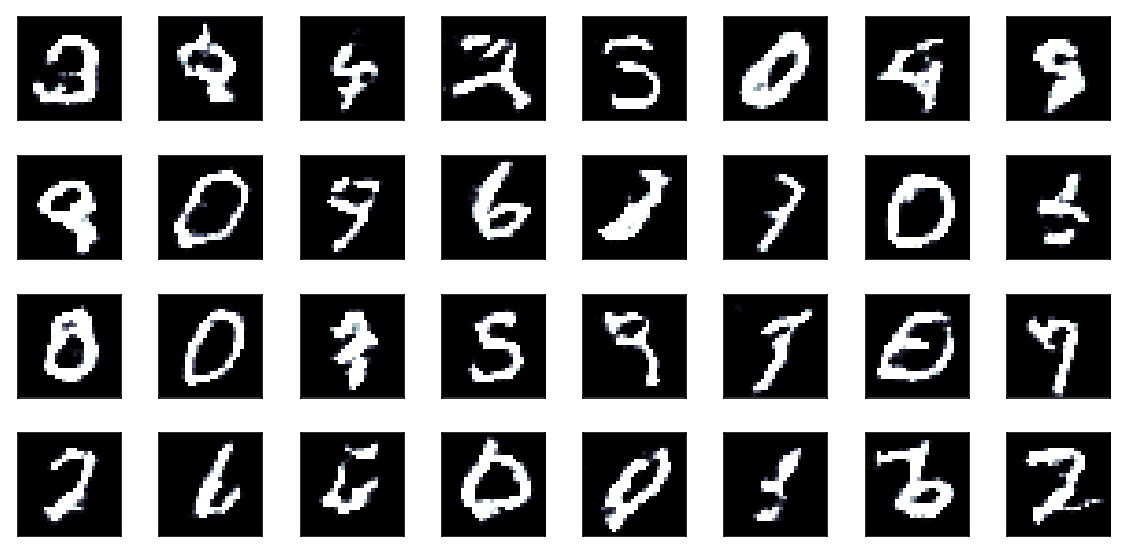

Epoch: 21/100 | Discriminator Loss: 1.3923 | Generator Loss: 0.8907
Epoch: 22/100 | Discriminator Loss: 4.6019 | Generator Loss: 5.0805
Epoch: 23/100 | Discriminator Loss: 3.1675 | Generator Loss: 3.2764
Epoch: 24/100 | Discriminator Loss: 3.3627 | Generator Loss: 4.0304
Epoch: 25/100 | Discriminator Loss: 2.9298 | Generator Loss: 3.5067
Epoch: 26/100 | Discriminator Loss: 3.0301 | Generator Loss: 3.4014
Epoch: 27/100 | Discriminator Loss: 5.1763 | Generator Loss: 5.8999
Epoch: 28/100 | Discriminator Loss: 1.6347 | Generator Loss: 2.5965
Epoch: 29/100 | Discriminator Loss: 2.8280 | Generator Loss: 3.1276
Epoch: 30/100 | Discriminator Loss: 4.7573 | Generator Loss: 5.8873
Epoch: 31/100 | Discriminator Loss: 1.3049 | Generator Loss: 1.4666
Epoch: 32/100 | Discriminator Loss: 4.3069 | Generator Loss: 5.0140
Epoch: 33/100 | Discriminator Loss: 1.3717 | Generator Loss: 2.3295
Epoch: 34/100 | Discriminator Loss: 2.3558 | Generator Loss: 2.3697
Epoch: 35/100 | Discriminator Loss: 4.3318 | Gen

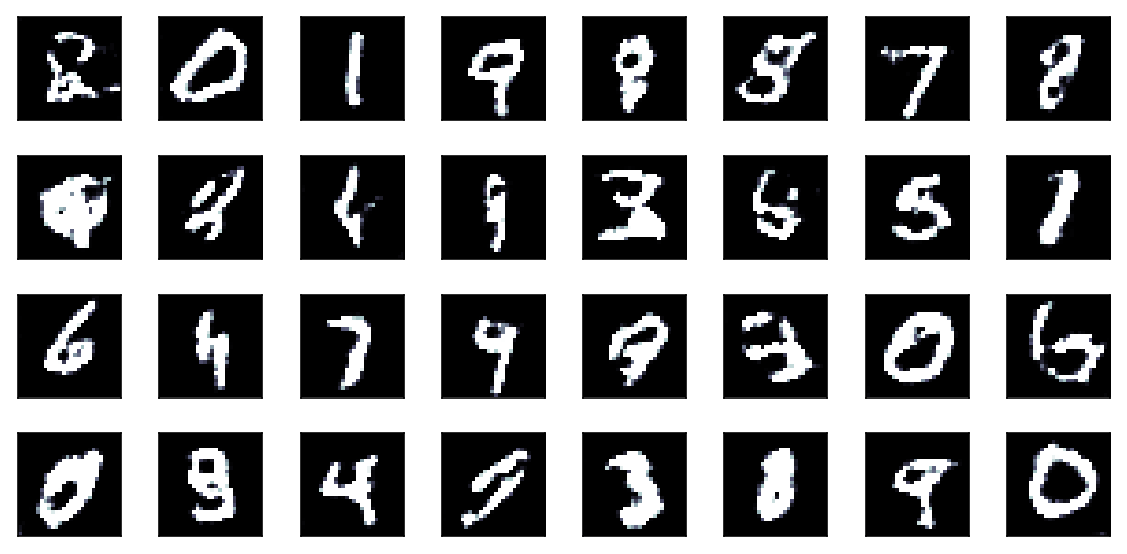

Epoch: 41/100 | Discriminator Loss: 5.1421 | Generator Loss: 5.0581
Epoch: 42/100 | Discriminator Loss: 4.1990 | Generator Loss: 5.3048
Epoch: 43/100 | Discriminator Loss: 5.1553 | Generator Loss: 5.2653
Epoch: 44/100 | Discriminator Loss: 4.4203 | Generator Loss: 4.9082
Epoch: 45/100 | Discriminator Loss: 1.8183 | Generator Loss: 0.8382
Epoch: 46/100 | Discriminator Loss: 3.9580 | Generator Loss: 3.9405
Epoch: 47/100 | Discriminator Loss: 1.7800 | Generator Loss: 1.3958
Epoch: 48/100 | Discriminator Loss: 1.5923 | Generator Loss: 1.2896
Epoch: 49/100 | Discriminator Loss: 5.7207 | Generator Loss: 6.8637
Epoch: 50/100 | Discriminator Loss: 2.1589 | Generator Loss: 0.4639
Epoch: 51/100 | Discriminator Loss: 1.8943 | Generator Loss: 0.5961
Epoch: 52/100 | Discriminator Loss: 1.0285 | Generator Loss: 0.9477
Epoch: 53/100 | Discriminator Loss: 2.5925 | Generator Loss: 0.2106
Epoch: 54/100 | Discriminator Loss: 2.0665 | Generator Loss: 0.4503
Epoch: 55/100 | Discriminator Loss: 3.9392 | Gen

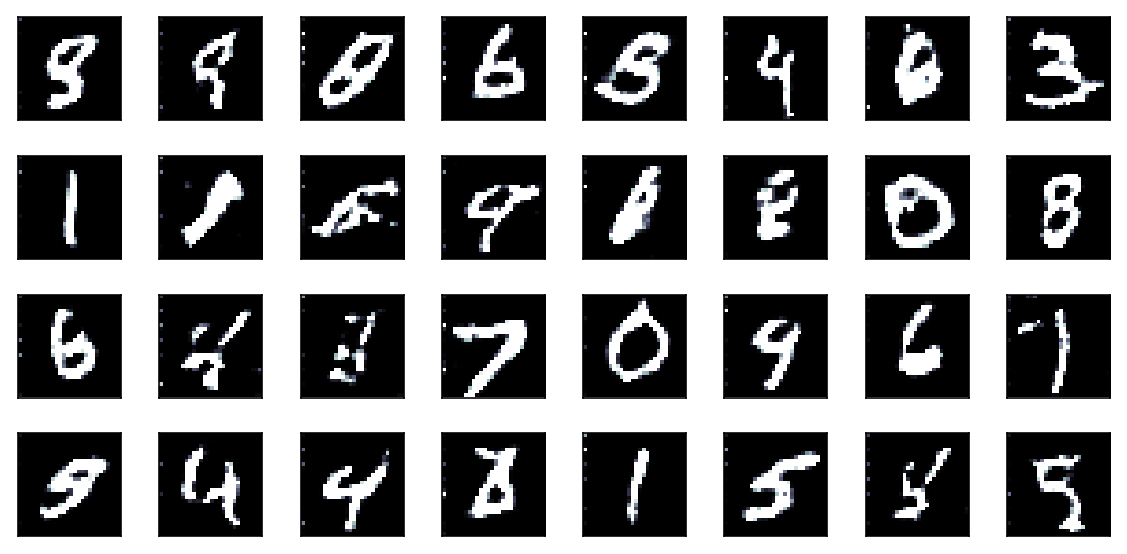

Epoch: 61/100 | Discriminator Loss: 1.8119 | Generator Loss: 0.8243
Epoch: 62/100 | Discriminator Loss: 2.5155 | Generator Loss: 0.3281
Epoch: 63/100 | Discriminator Loss: 2.2110 | Generator Loss: 2.1846
Epoch: 64/100 | Discriminator Loss: 1.2999 | Generator Loss: 1.4672
Epoch: 65/100 | Discriminator Loss: 2.6104 | Generator Loss: 3.3032
Epoch: 66/100 | Discriminator Loss: 1.2322 | Generator Loss: 1.0923
Epoch: 67/100 | Discriminator Loss: 4.4450 | Generator Loss: 0.0403
Epoch: 68/100 | Discriminator Loss: 3.0417 | Generator Loss: 0.1283
Epoch: 69/100 | Discriminator Loss: 2.0966 | Generator Loss: 0.5244
Epoch: 70/100 | Discriminator Loss: 4.6092 | Generator Loss: 0.0589
Epoch: 71/100 | Discriminator Loss: 1.5955 | Generator Loss: 1.7555
Epoch: 72/100 | Discriminator Loss: 2.6298 | Generator Loss: 0.3233
Epoch: 73/100 | Discriminator Loss: 2.1934 | Generator Loss: 2.9467
Epoch: 74/100 | Discriminator Loss: 1.2804 | Generator Loss: 1.2850
Epoch: 75/100 | Discriminator Loss: 2.3548 | Gen

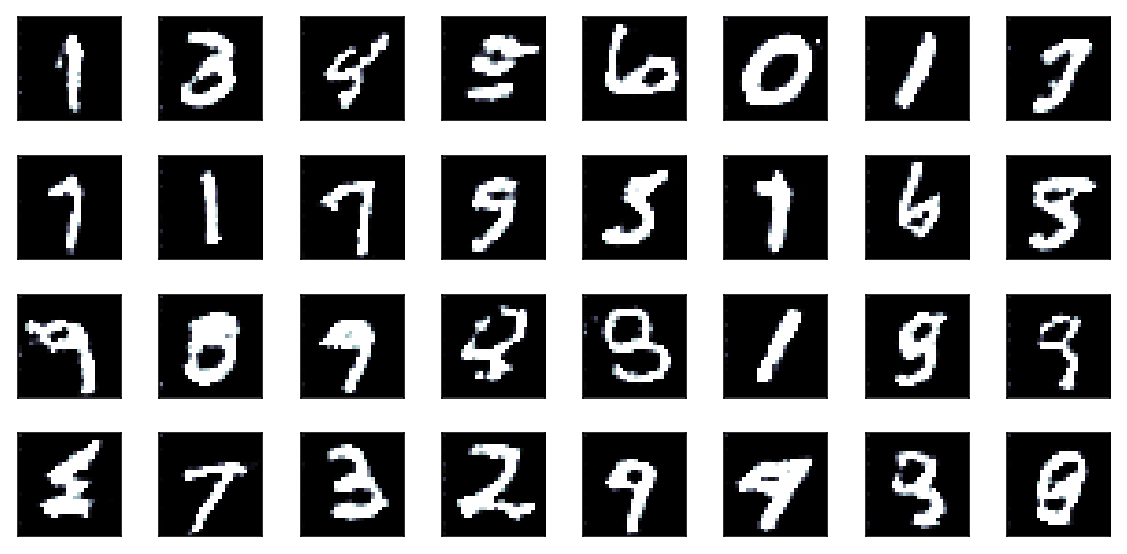

Epoch: 81/100 | Discriminator Loss: 1.6806 | Generator Loss: 1.9974
Epoch: 82/100 | Discriminator Loss: 3.6858 | Generator Loss: 4.8186
Epoch: 83/100 | Discriminator Loss: 1.8770 | Generator Loss: 1.2339
Epoch: 84/100 | Discriminator Loss: 2.5333 | Generator Loss: 2.5002
Epoch: 85/100 | Discriminator Loss: 2.3066 | Generator Loss: 3.1923
Epoch: 86/100 | Discriminator Loss: 1.3927 | Generator Loss: 1.3137
Epoch: 87/100 | Discriminator Loss: 2.9532 | Generator Loss: 3.8107
Epoch: 88/100 | Discriminator Loss: 1.6300 | Generator Loss: 0.7226
Epoch: 89/100 | Discriminator Loss: 2.0440 | Generator Loss: 2.6493
Epoch: 90/100 | Discriminator Loss: 1.6585 | Generator Loss: 2.1207
Epoch: 91/100 | Discriminator Loss: 1.8874 | Generator Loss: 2.2200
Epoch: 92/100 | Discriminator Loss: 1.8399 | Generator Loss: 2.6997
Epoch: 93/100 | Discriminator Loss: 2.1350 | Generator Loss: 0.7035
Epoch: 94/100 | Discriminator Loss: 2.2212 | Generator Loss: 2.3413
Epoch: 95/100 | Discriminator Loss: 3.3984 | Gen

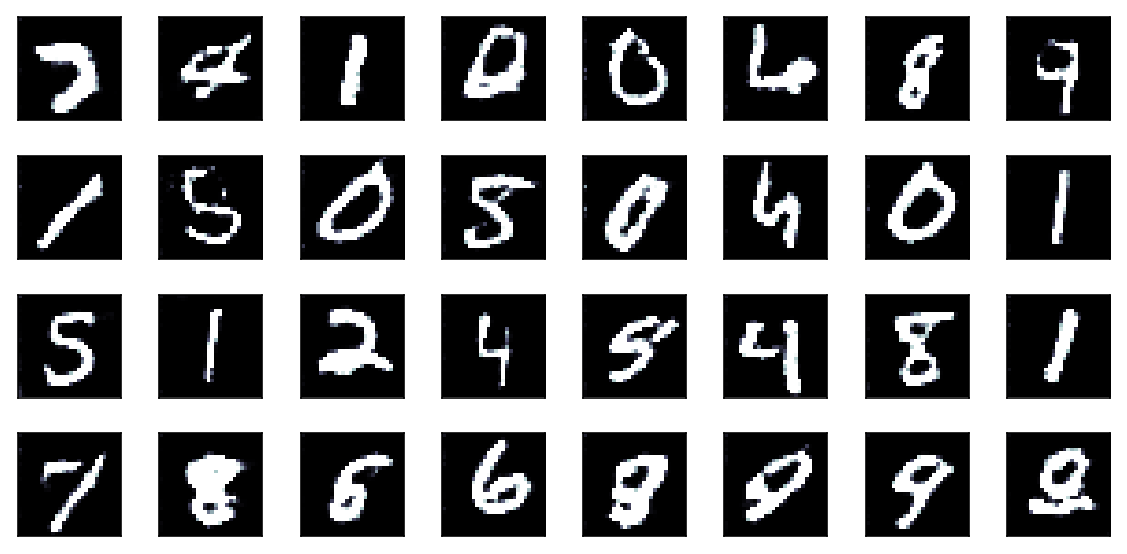

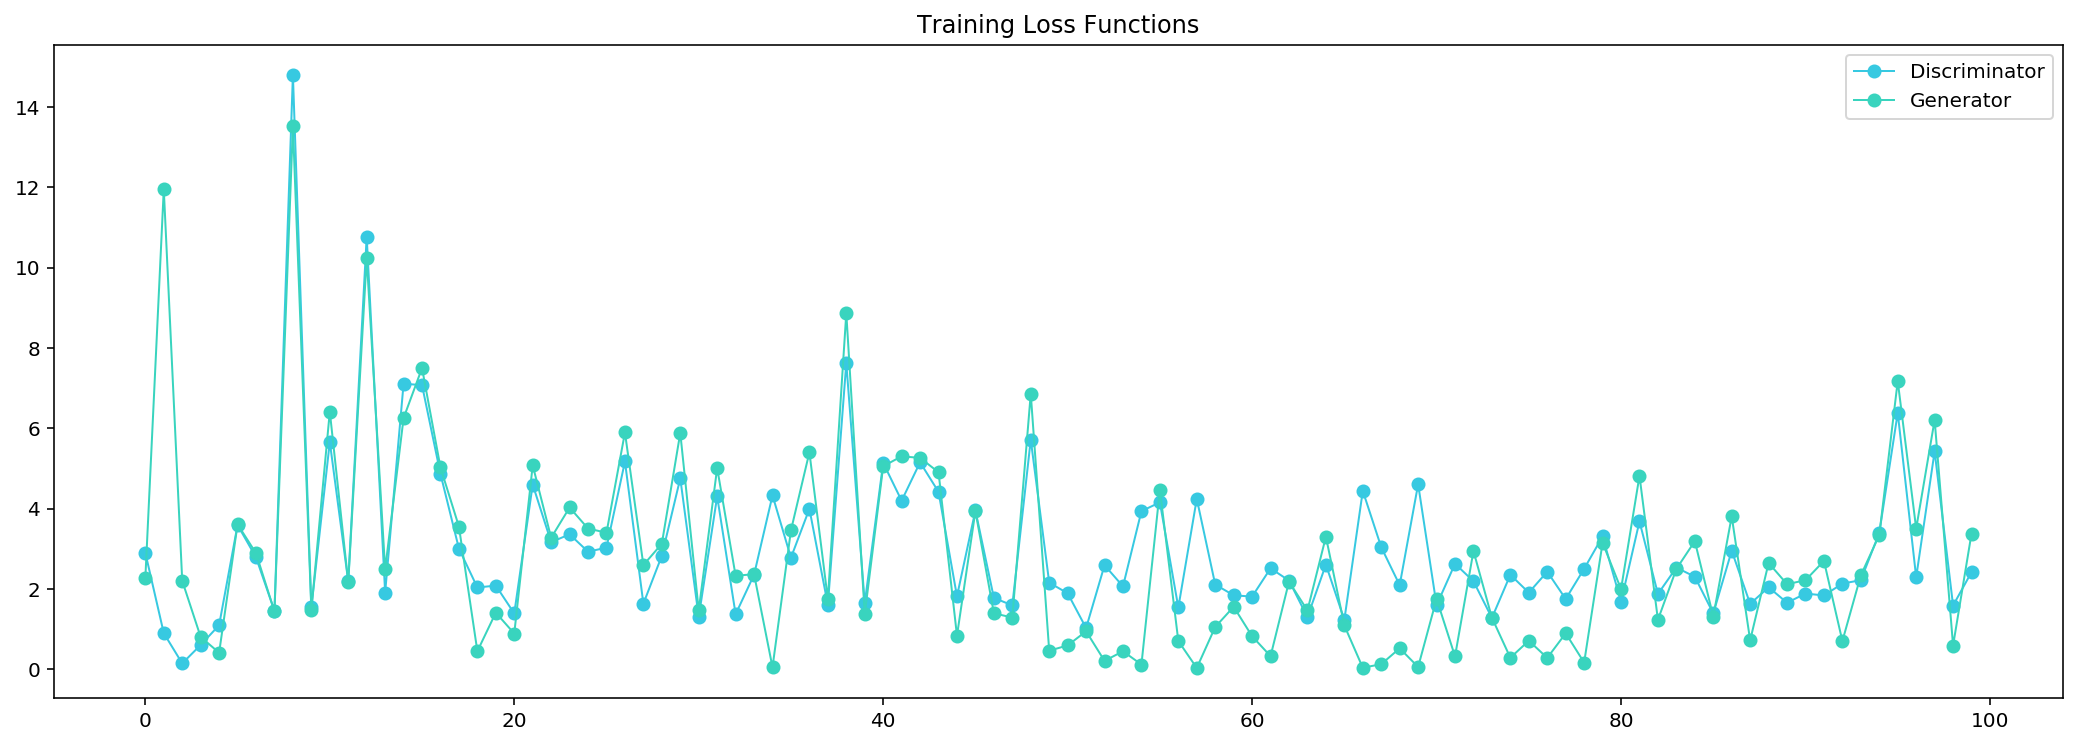

In [58]:
dcgan_train(g_learning_rate=0.0002, g_beta_1=0.8, 
            d_learning_rate=0.001, d_beta_1=0.8, 
            leaky_alpha=0.01);

## TensorFlow NN 

In [4]:
def get_batches(images, batch_size):
    current_index = 0
    while current_index + batch_size <= images.shape[0]:
        data_batch = images[current_index:current_index + batch_size]
        current_index += batch_size
        yield data_batch / 255 - 0.5 

def images_square_grid(images, mode):
    save_size = math.floor(np.sqrt(images.shape[0]))
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    images_in_square = np.reshape(images[:save_size*save_size],
                                  (save_size, save_size, 
                                   images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

In [87]:
digit_images = digit_images.reshape(-1, 28, 28, 1)

In [88]:
stddev = 0.01
alpha = 0.1
learning_rate = 0.00025
beta1 = 0.5 
z_dim = 128
batch_size = 32
epochs = 2

In [11]:
def nn_inputs(image_width, image_height, image_channels, z_dim):
    input_real = tf.placeholder(tf.float32, 
                                shape=[None, image_width, image_height, image_channels], # rank 4
                                name="Real_Input") 
    
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Z_Input") # rank 2    
    input_learning_rate = tf.placeholder(tf.float32, shape=[], name="Learning_Rate") # rank 0
    
    return input_real, input_z, input_learning_rate

In [12]:
def nn_discriminator(images, reuse=False, alpha=alpha):
    with tf.variable_scope('discriminator', reuse=reuse):
        # image shape [28,28,3]
        x = tf.layers.conv2d(images, 32, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x) 
        
        # input shape [14,14,32]       
        x = tf.layers.conv2d(x, 96, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x)        
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [7,7,96]        
        x = tf.layers.conv2d(x, 128, 5, strides=2,
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev), 
                             padding='same')
        x = tf.maximum(x * alpha, x)       
        x = tf.layers.batch_normalization(x, training=True)

        # input shape [4,4,128]       
        x = tf.reshape(x, (-1, 4*4*128))
        
        discriminator_logits = tf.layers.dense(x, 1)
        discriminator_outputs = tf.sigmoid(discriminator_logits)
        
    return discriminator_outputs, discriminator_logits

In [13]:
def nn_generator(z, out_channel_dim, is_train=True, alpha=alpha):
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x = tf.layers.dense(z, 7*7*128)
        x = tf.reshape(x, (-1, 7, 7, 128))
        x = tf.maximum(x * alpha, x)          
        x = tf.layers.batch_normalization(x, training=is_train)
        
        # input shape [7,7,128]       
        x = tf.layers.conv2d_transpose(x, 96, 5, strides=2, 
                                       kernel_initializer=\
                                       tf.random_normal_initializer(stddev=stddev), 
                                       padding='same')
        x = tf.maximum(x * alpha, x)          
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [14,14,96]
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2,
                                       kernel_initializer=\
                                       tf.random_normal_initializer(stddev=stddev), 
                                       padding='same')
        x = tf.maximum(x * alpha, x)              
        x = tf.layers.batch_normalization(x, training=is_train)

        # input shape [28,28,32]        
        generator_logits = \
        tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, 
                                   kernel_initializer=\
                                   tf.random_normal_initializer(stddev=stddev), 
                                   padding='same')

        # input shape [28,28,3]         
        generator_outputs = tf.tanh(generator_logits)
    
    return generator_outputs    

In [14]:
def nn_loss(input_real, input_z, out_channel_dim, alpha=alpha, index="leaky_relu"):    
    if index=="relu":
        img_generator = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = discriminator(input_real, reuse=False, alpha=alpha)
        generator_outputs, generator_logits = discriminator(img_generator, 
                                                            reuse=True, alpha=alpha)
    elif index=="leaky_relu":
        img_generator = nn_generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
        real_outputs, real_logits = nn_discriminator(input_real, alpha=alpha)
        generator_outputs, generator_logits = nn_discriminator(img_generator, 
                                                               reuse=True, alpha=alpha)        
    
    real_labels = tf.ones_like(real_outputs) * (1 - alpha)
    zeros_labels = tf.zeros_like(generator_outputs)
    ones_labels = tf.ones_like(generator_outputs)

    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                                       labels=real_labels))
    zeros_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                        labels=zeros_labels))
    ones_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generator_logits, 
                                                                       labels=ones_labels))

    return real_loss + zeros_loss, ones_loss

In [15]:
def nn_optimizer(discriminator_loss, generator_loss, learning_rate, beta1):

    trainable_variables = tf.trainable_variables()
    discriminator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('discriminator')]
    generator_trainable_variables = \
    [v for v in trainable_variables if v.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_update_ops = \
    [u for u in update_ops if u.name.startswith('discriminator')]
    generator_update_ops = \
    [u for u in update_ops if u.name.startswith('generator')]

    with tf.control_dependencies(discriminator_update_ops):
        discriminator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                                   beta1=beta1).\
        minimize(discriminator_loss, var_list=discriminator_trainable_variables)

    with tf.control_dependencies(generator_update_ops):
        generator_training_operations = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                               beta1=beta1).\
        minimize(generator_loss, var_list=generator_trainable_variables)
            
    return discriminator_training_operations, generator_training_operations

In [16]:
def nn_train(images, epoch_count, batch_size, z_dim, learning_rate, beta1, 
             data_shape, data_image_mode, print_step, show_step):
    
    input_real, input_z, input_learning_rate = \
    nn_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    discriminator_loss, generator_loss = \
    nn_loss(input_real, input_z, data_shape[3], alpha=alpha, index="leaky_relu")
    
    discriminator_training_operations, generator_training_operations = \
    nn_optimizer(discriminator_loss, generator_loss, learning_rate, beta1)
    
    train_step = 0
    DTL, GTL = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(images, batch_size):
                train_step += 1
                batch_images *= 2.0                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_training_operations, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(generator_training_operations, 
                             feed_dict={input_z: batch_z})

                if train_step % print_step == 0:
                    discriminator_training_loss = \
                    discriminator_loss.eval({input_real: batch_images, input_z: batch_z})
                    generator_training_loss= \
                    generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}| Step {}|".format(epoch_i + 1, epochs, train_step),
                          "Discriminator Loss:{:.5f}|".format(discriminator_training_loss),
                          "Generator Loss:{:.5f}|".format(generator_training_loss),
                          "DL > GL: {}"\
                          .format(discriminator_training_loss>generator_training_loss))
                    
                    DTL.append(discriminator_training_loss) 
                    GTL.append(generator_training_loss) 
                    
                if train_step % show_step == 0:
                    cmap = None if data_image_mode == 'RGB' else cm.bone
                    z_dim = input_z.get_shape().as_list()[-1]
                    example_z = np.random.uniform(-1, 1, size=[64, z_dim])

                    samples = sess.run(nn_generator(input_z, data_shape[3], False),
                                       feed_dict={input_z: example_z})

                    images_grid = images_square_grid(samples, data_image_mode)
                    plt.figure(figsize=(8, 8))
                    plt.imshow(images_grid, cmap=cmap)
                    plt.xticks([])
                    plt.yticks([])
                    plt.show()
                            
    plt.figure(figsize=(18, 6))
    plt.plot(DTL, '-o', c='#37c9e1', lw=1, label = 'Discriminator')
    plt.plot(GTL, '-o', c='#39d4be', lw=1, label = 'Generator')
    plt.legend()
    plt.title('Training Loss Functions');

## Generate Images

Epoch 1/2| Step 100| Discriminator Loss:0.38394| Generator Loss:3.73422| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 200| Discriminator Loss:1.40437| Generator Loss:0.47306| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 300| Discriminator Loss:1.53368| Generator Loss:0.52828| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 400| Discriminator Loss:1.01585| Generator Loss:1.29975| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 500| Discriminator Loss:1.00561| Generator Loss:1.16793| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 600| Discriminator Loss:1.73392| Generator Loss:0.34705| Discriminator Loss>Generator Loss: True


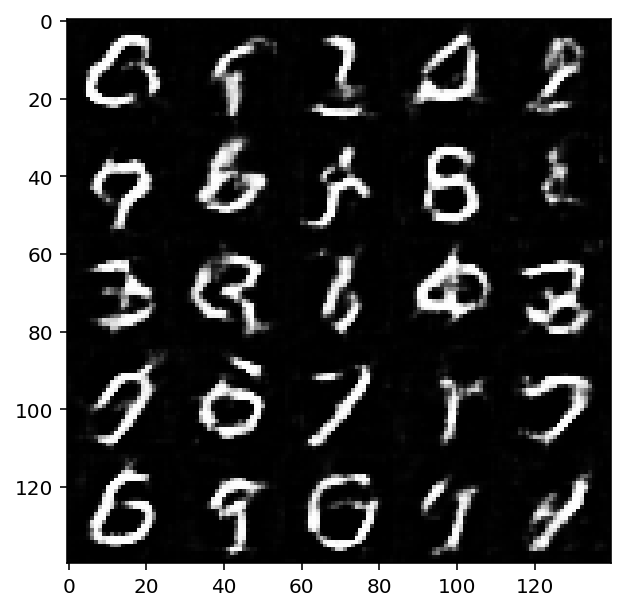

Epoch 1/2| Step 700| Discriminator Loss:0.96983| Generator Loss:1.10805| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 800| Discriminator Loss:1.26437| Generator Loss:0.72652| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 900| Discriminator Loss:1.32310| Generator Loss:0.64156| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1000| Discriminator Loss:1.00414| Generator Loss:1.08337| Discriminator Loss>Generator Loss: False
Epoch 1/2| Step 1100| Discriminator Loss:0.98328| Generator Loss:0.98233| Discriminator Loss>Generator Loss: True
Epoch 1/2| Step 1200| Discriminator Loss:1.05625| Generator Loss:0.94466| Discriminator Loss>Generator Loss: True


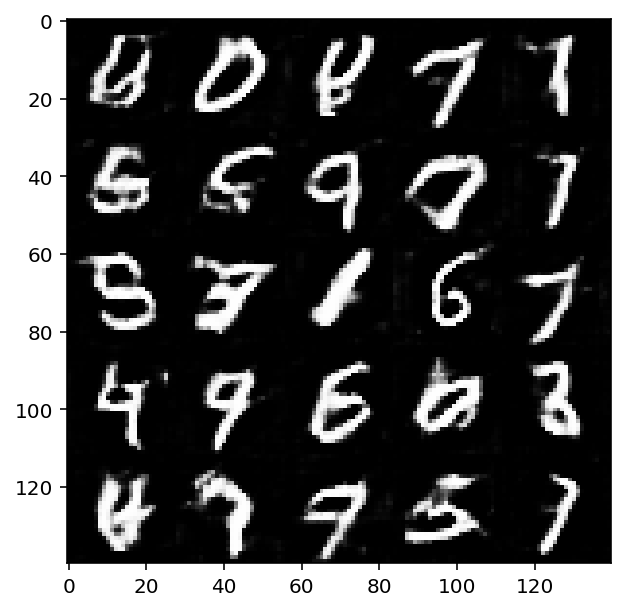

Epoch 1/2| Step 1300| Discriminator Loss:1.07181| Generator Loss:1.14296| Discriminator Loss>Generator Loss: False
Epoch 2/2| Step 1400| Discriminator Loss:0.95118| Generator Loss:1.16843| Discriminator Loss>Generator Loss: False
Epoch 2/2| Step 1500| Discriminator Loss:1.22192| Generator Loss:0.71517| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1600| Discriminator Loss:1.46665| Generator Loss:0.53041| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1700| Discriminator Loss:1.33533| Generator Loss:0.56873| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 1800| Discriminator Loss:1.31337| Generator Loss:0.66507| Discriminator Loss>Generator Loss: True


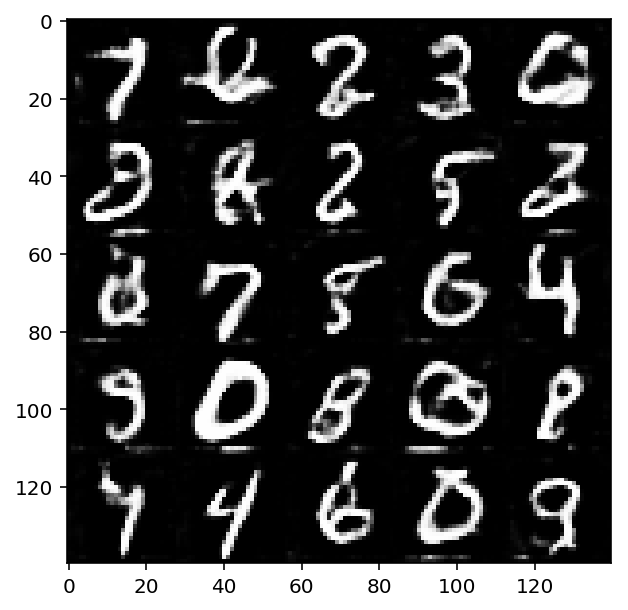

Epoch 2/2| Step 1900| Discriminator Loss:1.19518| Generator Loss:1.15905| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2000| Discriminator Loss:1.21053| Generator Loss:0.67634| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2100| Discriminator Loss:1.22163| Generator Loss:0.70871| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2200| Discriminator Loss:1.37539| Generator Loss:0.53858| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2300| Discriminator Loss:1.15832| Generator Loss:0.76972| Discriminator Loss>Generator Loss: True
Epoch 2/2| Step 2400| Discriminator Loss:1.40754| Generator Loss:0.63138| Discriminator Loss>Generator Loss: True


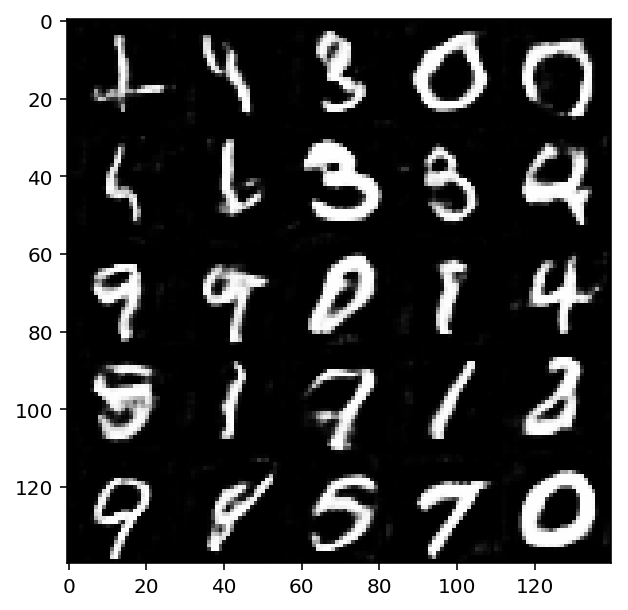

Epoch 2/2| Step 2500| Discriminator Loss:0.77169| Generator Loss:1.58712| Discriminator Loss>Generator Loss: False
Epoch 2/2| Step 2600| Discriminator Loss:1.31416| Generator Loss:0.60325| Discriminator Loss>Generator Loss: True


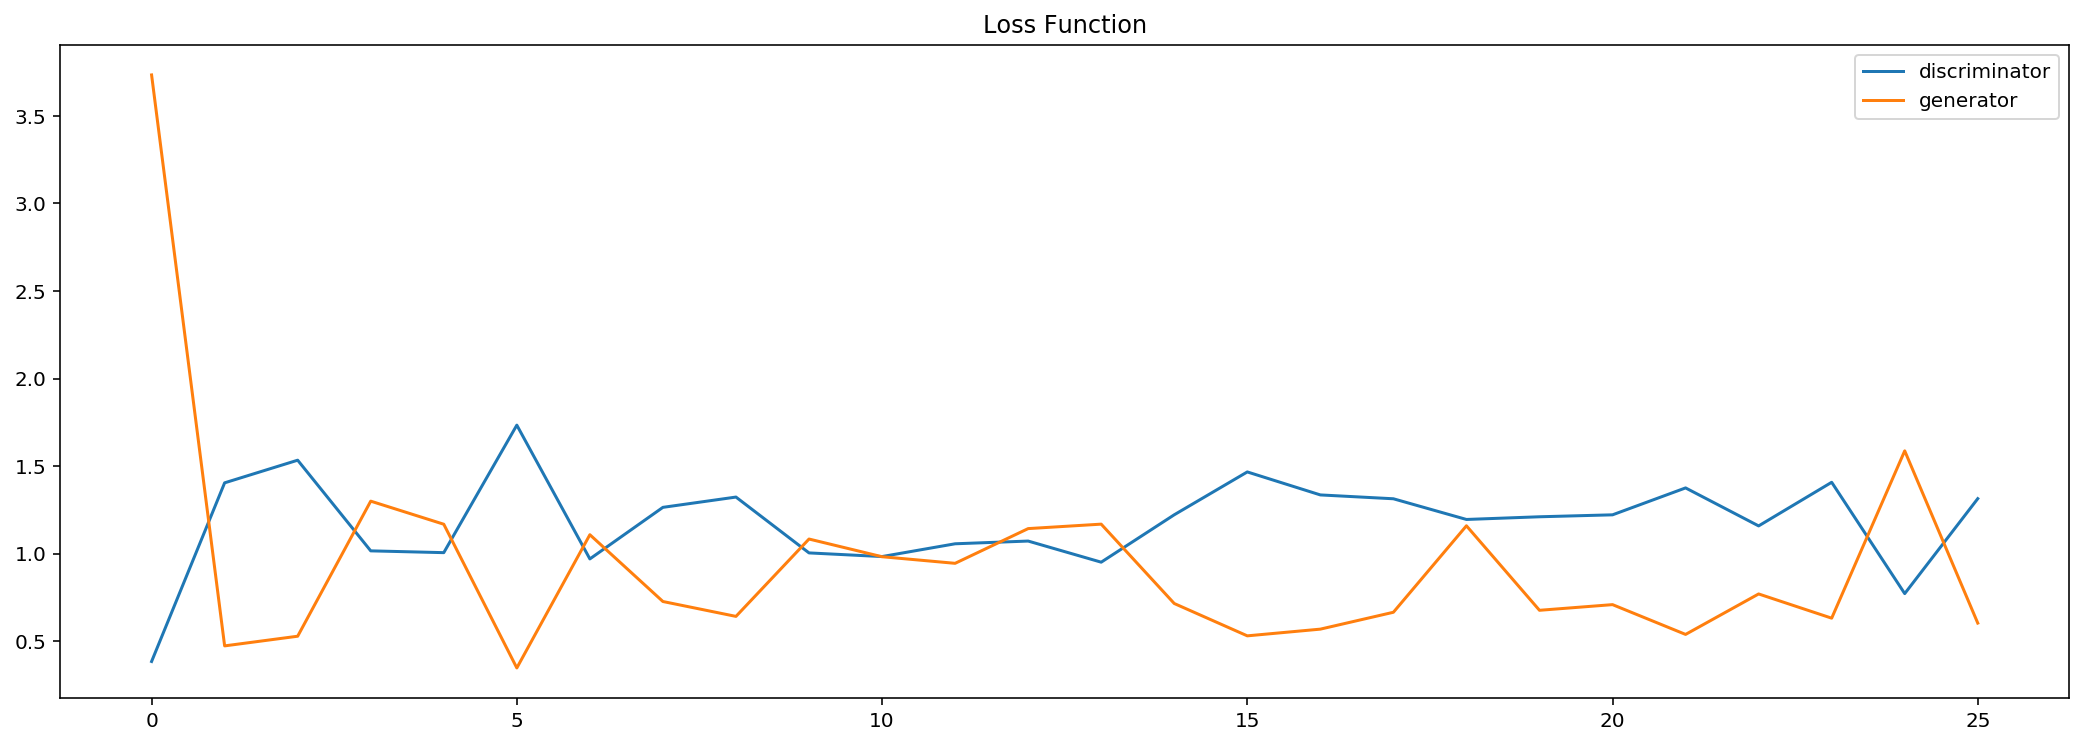

In [24]:
with tf.Graph().as_default():
    nn_train(digit_images, epochs, batch_size, 
             z_dim, learning_rate, beta1, 
             digit_images.shape, "L", 100, 600)